In [3]:
try:
    import pymc as pm
except:
    %pip install pymc==5.8.0    
    import pymc as pm
    
print(pm.__version__)

%pip install --force-reinstall --no-deps git+https://github.com/pymc-devs/pymc-bart.git@main
#try:
import pymc_bart as pmb
#except:
#    %pip install pymc-bart
#    import pymc_bart as pmb
    

print(pmb.__version__)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import os
import pickle

5.8.0
  Cloning https://github.com/pymc-devs/pymc-bart.git (to revision main) to /tmp/pip-req-build-eax8accf
  Running command git clone --filter=blob:none --quiet https://github.com/pymc-devs/pymc-bart.git /tmp/pip-req-build-eax8accf
  Resolved https://github.com/pymc-devs/pymc-bart.git to commit 709d3c4d08d5e17740db25e52b66c6e0846879c3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pymc-bart: filename=pymc_bart-0.5.1-py3-none-any.whl size=32982 sha256=8d36a01be5c47531a19e6607c0305a6158dcd2b4890ad695a7c0fedbffd1e98e
  Stored in directory: /tmp/pip-ephem-wheel-cache-t11r0mwc/wheels/dd/bb/fa/be5eab50aea9b866e2b73d658b13b91fe445e12c4a1a18fe7a
Successfully built pymc-bart
  Attempting uninstall: pymc-bart
    Found existing installation: pymc-bart 0.5.1
    Uninstalling pymc-bart-0.5.1:
      Successfully uninstalled pymc-bart-0.5.1

[notice] A new release of pip is available: 23.1.

In [4]:
# configure training/testing environment
tree_fname = 'BART_simple_forest.pkl' # filename
data_fname = 'BART_simple_data.pkl'

generate_and_save_data = 0 # otherwise load data
train_model = 1
save_model = 1 # otherwise load model
pred_data = 1

# useful functions
def get_predictions_from_trees(forests, x_te):
    # sample from each forest in forests
    # forests is a list of a list.
    # the outer list contains each forest
    # each forest contains trees. Average predictions from each tree in a forest, output each forest prediction
    # output is x_te.shape[0] x N_forests
    
    pred_out = np.zeros((x_te.shape[0], len(forests)))
    for i_forest in range(len(forests)):
        trees = forests[i_forest]
        temp_pred = 0
        for tree in trees:
            temp_pred += tree.predict(x_te)
        pred_out[:,i_forest] = temp_pred
    return pred_out

def invlogit(x):
    return 1/(1+np.exp(-x))

def sample_posterior(forests, x_te):
    forest_pred = get_predictions_from_trees(forests,x_te)
    return invlogit(forest_pred)

Only 10 samples in chain.
Sequential sampling (1 chains in 1 job)
PGBART: [mu]


Sampling 1 chain for 2 tune and 10 draw iterations (2 + 10 draws total) took 88 seconds.
The number of samples is too small to check convergence reliably.
/tmp/ipykernel_23118/2814940427.py:64: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  posterior_train = pm.sample_posterior_predictive(trace=idata_train,
Sampling: []


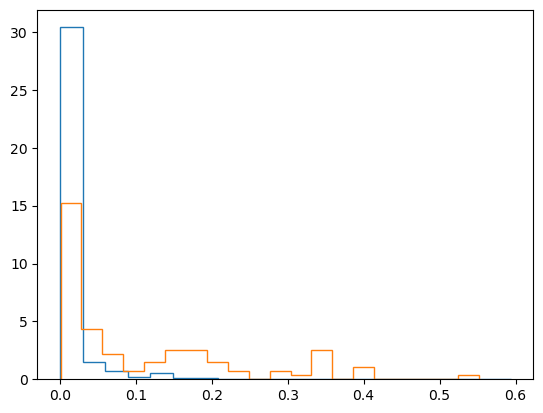

In [33]:
if generate_and_save_data:
    n1 = 10550 # n in each class
    n2 = 150
    n_dim = 10

    mean1 = 1
    std1 = 1
    mean2 = 2
    std2 = 1

    x1 = np.random.randn(n1,n_dim)*std1 + mean1
    y1 = np.zeros((n1,))
    x2 = np.random.randn(n2,n_dim)*std2 + mean2
    y2 = np.ones((n2,))

    x_in = np.concatenate((x1,x2),axis=0)
    y_in = np.concatenate((y1,y2),axis=0)

    x_tr, x_te, y_tr, y_te = train_test_split(x_in, y_in, test_size=0.33)

    plt.figure()
    plt.hist(x1[:,0],bins=20,histtype='step',density=True);
    plt.hist(x2[:,0],bins=20,histtype='step',density=True);

    with open(data_fname,'wb') as f:
        pickle.dump({'x_tr':x_tr,'y_tr':y_tr,'x_te':x_te,'y_te':y_te},f)
    
else:
    with open(data_fname,'rb') as f:
        data = pickle.load(f)
        
    x_tr = data['x_tr']
    y_tr = data['y_tr']
    x_te = data['x_te']
    y_te = data['y_te']
    
# set scale weight based on y_tr
weights  = np.ones((x_tr.shape[0],))   
scale_pos_weight = np.sum(y_tr==0)/np.sum(y_tr==1)
weights[y_tr==1] = scale_pos_weight

# set split prior
#split_prior = np.ones(x_tr.shape[1])
split_prior = np.zeros(x_tr.shape[1])
split_prior[0]=1
split_prior[1]=1

# define and train model
if train_model:
    with pm.Model() as bart_model:
        X = pm.MutableData("X", x_tr, dims=("obs","feature"))
        Y = y_tr
                
        mu = pmb.BART("mu", X=X, Y=Y, m=10, dims="obs", shape=X.shape[0], split_prior=split_prior)#np.random.rand(x_tr.shape[1]))
        
        p = pm.Deterministic('p', pm.math.invlogit(mu), dims="obs")
        
        pm.Potential('weights', 
             weights * pm.Bernoulli("y", p=p, observed=Y, dims="obs",shape=p.shape[0]))
        #y = pm.Bernoulli("y", p=p, observed=Y, dims="obs",shape=p.shape[0])#shape=p.shape)

        idata_train = pm.sample(tune=2,draws=10,chains=1)
        
        posterior_train = pm.sample_posterior_predictive(trace=idata_train,
                                                              var_names=["p"])
    
    prior_train = posterior_train.posterior_predictive.p.mean(axis=1).mean(axis=0).T

    plt.figure()
    plt.hist(prior_train[y_tr==0],histtype='step',bins=20,density=True);
    plt.hist(prior_train[y_tr==1],histtype='step',bins=20,density=True);

[[1813 1668]
 [  16   34]]


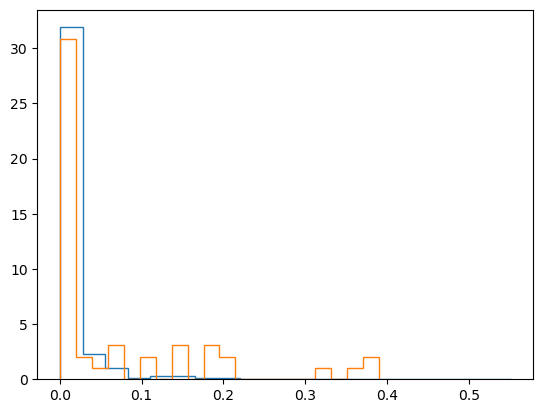

In [34]:
forests = []
for i in range(len(pmb.BART.all_trees)):
    trees = []
    for j in range(len(pmb.BART.all_trees[i])):
        for k in range(pmb.BART.all_trees[i][j].shape[0]):
            trees.append(pmb.BART.all_trees[i][j][k])

    forests.append(trees)

if pred_data:
    x_in = x_te
    y_in = y_te
    
    pred_per_forest = sample_posterior(forests,x_in)
    pred_mean = np.mean(pred_per_forest,axis=1)

    plt.hist(pred_mean[y_in==0],histtype='step',bins=20,density=True);
    plt.hist(pred_mean[y_in==1],histtype='step',bins=20,density=True);
    print(confusion_matrix(y_true=y_te, y_pred=pred_mean>np.percentile(pred_mean,50)))

In [35]:
split_var_count = {}
for i in range(x_tr.shape[1]):
    split_var_count[i] = 0
    
for i in range(len(forests)):
    for j in range(len(forests[i])):
        for split_var in forests[i][j].get_split_variables():
            split_var_count[split_var] = split_var_count[split_var] + 1

print(split_var_count)

{0: 147, 1: 189, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}


In [ ]:
if save_model:
    # extract trees in a nice structure....
    forests = []

    for i in range(len(pmb.BART.all_trees)):
        trees = []
        for j in range(len(pmb.BART.all_trees[i])):
            for k in range(pmb.BART.all_trees[i][j].shape[0]):
                trees.append(pmb.BART.all_trees[i][j][k])

        forests.append(trees)
    
    with open(tree_fname, 'wb') as f:
        pickle.dump({'forests':forests},f)
else:
    with open(tree_fname,'rb') as f:
        forest_data = pickle.load(f)
    forests = forest_data['forests']

In [ ]:
if pred_data:
    x_in = x_te
    y_in = y_te
    
    pred_per_forest = sample_posterior(forests,x_in)
    pred_mean = np.mean(pred_per_forest,axis=1)

    plt.hist(pred_mean[y_in==0],histtype='step',bins=20,density=True);
    plt.hist(pred_mean[y_in==1],histtype='step',bins=20,density=True);
    print(confusion_matrix(y_true=y_te, y_pred=pred_mean>np.percentile(pred_mean,50)))